In [725]:
import cv2
import numpy as np
import json
import scipy.signal

import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

with open("iref_trim_per_module.json", "r") as f:
    data = json.load(f)

# Nombre de fils prévu

In [726]:
# Extraire le numéro de série d'un module depuis le nom du fichier

def extract_serial_number (file_name) :
    names = file_name.split("_")
    for x in names :
        if "20UPGM" in x :
            return (x)
    return (None)

In [727]:
# Lire les bits iref codés dans le json

def iref_trim (serialNumber, data) :
    error = True
    for x in data :
        if x['serialNumber'] == serialNumber :
            iref = x
            error = False
    if error :
        return ("serialNumber not found")
    return (iref['IREF_TRIM_1'], iref['IREF_TRIM_2'], iref['IREF_TRIM_3'], iref['IREF_TRIM_4'])

In [728]:
# Donner le nombre de fils attendus pour un certain module

def expected_wire_number (serialNumber, data) :
    iref = iref_trim(serialNumber, data)
    nb_wire_per_trim = [4, 3, 3, 2, 3, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 0]
    return (693 + nb_wire_per_trim[iref[0]] + nb_wire_per_trim[iref[1]] + nb_wire_per_trim[iref[2]] + nb_wire_per_trim[iref[3]])

# Comptage du nombre de fils réel

In [729]:
# Définir une zone verticale de recherche de fils (entre high et low)

def crop_lignes (image_grey) :
    image_bw = cv2.threshold(image_grey, 127,255,cv2.THRESH_BINARY_INV)[1]
    n = image_bw.shape[0]
    limit_high = 0
    x = image_bw[limit_high].mean()
    while (limit_high < n//2) and (x <= 150) :
        limit_high+=1
        x = image_bw[limit_high].mean()
    limit_low = n-1
    x = image_bw[limit_low].mean()
    while (limit_low > n//2) and (x <= 150) :
        limit_low-=1
        x = image_bw[limit_low].mean()
    return (limit_high + 20, limit_low - 30)

In [730]:
# Compter le nombre de fils à gauche et à droite

def count (image, column_left, column_right) :
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high, low = crop_lignes(grey)
    grey_crop = grey[high:low]
    peaks_left, _ = scipy.signal.find_peaks(grey_crop[:,column_left], distance=3, prominence=50, height=190, width=(0,10))
    peaks_right, _ = scipy.signal.find_peaks(grey_crop[:,column_right], distance=3, prominence=50, height=190, width=(0,10))
    return (peaks_left.shape[0] + peaks_right.shape[0])

In [731]:
# Dire si un module a le bon nombre de fils

def test_wire_number (file_name, data, column_left, column_right) :
    expected_nb = expected_wire_number(extract_serial_number(file_name), data)
    image = cv2.imread("ModulePictures/" + file_name)
    real_nb = count(image, column_left, column_right)
    return (expected_nb == real_nb, expected_nb, real_nb)

In [732]:
# Donner la position des fils trouvés

def wire_pos (image, column_left, column_right, level = 190) :
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high, low = crop_lignes(grey)
    grey_crop = grey[high:low]
    peaks_left, _ = scipy.signal.find_peaks(grey_crop[:,column_left], distance=3, prominence=50, height=190, width=(0,10))
    peaks_right, _ = scipy.signal.find_peaks(grey_crop[:,column_right], distance=3, prominence=50, height=190, width=(0,10))
    return(peaks_left, peaks_right)

# Tests

In [733]:
# Création des différents jeux de test

fichiers = [f for f in listdir("ModulePictures") if isfile(join("ModulePictures", f))]
fichiersOK = []
fichiersNOK = []

for x in fichiers :
    if not("NoLight" in x) and not("GA4" in x) :
        if "NOK" in x:
            fichiersNOK.append(x)
        else :
            fichiersOK.append(x)

len(fichiersOK), len(fichiersNOK)

(10, 24)

In [734]:
# TEST sur les modules OK

columns_left = [740, 750, 800, 780, 830, 800, 890, 890, 740, 830]
columns_right = [6130, 6080, 6130, 6110, 6140, 6100, 6210, 6210, 6050, 6150]

for i in range(len(fichiersOK)) :
    print(test_wire_number(fichiersOK[i], data, columns_left[i], columns_right[i]))

# ATTENTION : P1024_20UPGM23211820_AfterWirebonding.jpg
# pb à 900 à cause d'un petit point blanc !!

(True, 700, 700)
(True, 700, 700)
(True, 699, 699)
(True, 701, 701)
(True, 701, 701)
(True, 700, 700)
(True, 698, 698)
(True, 700, 700)
(True, 697, 697)
(True, 700, 700)


# Tests plus poussés sur un module particulier

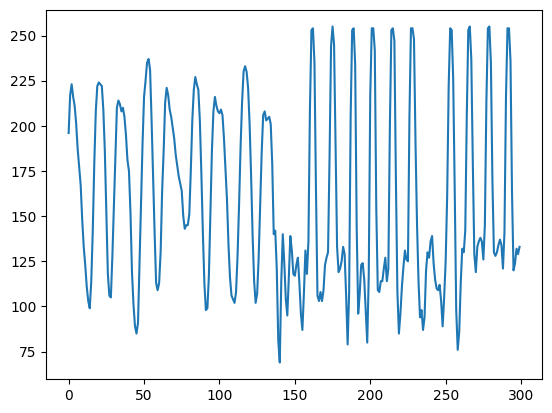

In [735]:
image = cv2.imread('ModulePictures/20UPGM23211355_PPPV2_46_AfterBonding.jpg')
left = 740
right = 6130
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
n = grey.shape[0]
plt.plot(np.arange(grey.shape[0])[:300], grey[:,left][:300])

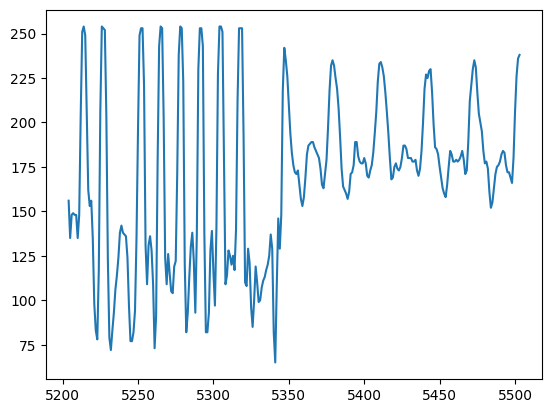

In [736]:
plt.plot(np.arange(grey.shape[0])[n-300:], grey[:,right][n-300:])

In [737]:
high, low = crop_lignes(image)
image_crop = image[high:low]

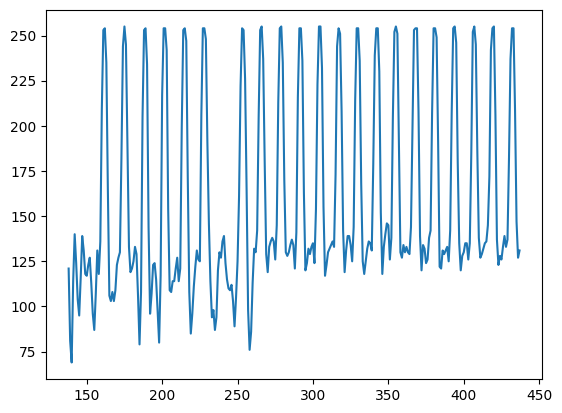

In [738]:
plt.plot(np.arange(low-high)[:300]+high, grey[high:low,left][:300])

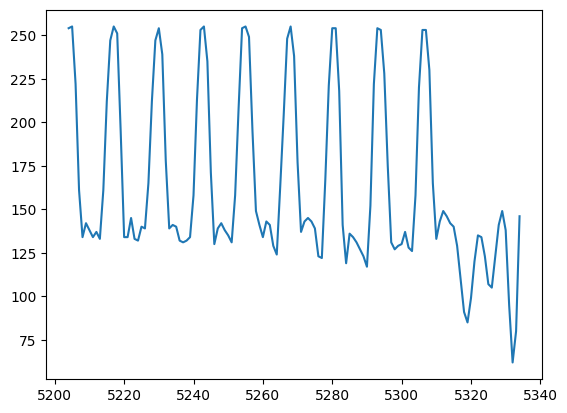

In [739]:
plt.plot(np.arange(low-high)[n-high-300:]+high, grey[high:low,left][n-high-300:])

In [740]:
image2 = image_crop.copy()
test = wire_pos(image_crop, left, right)
for x in test :
    image2[x, left, 0] = 0
    image2[x, left, 1] = 0
    image2[x, left, 2] = 255
cv2.imwrite('test.jpg',image2)

True